In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [2]:
data_dir = tools.select_data_dir()

The data directory is ../data


In [3]:
device = torch.device('cpu')

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

In [5]:
trainloader

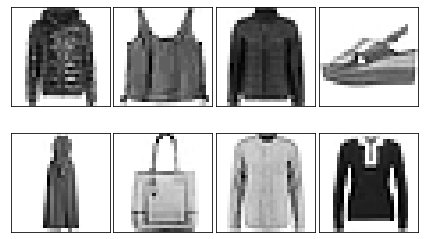

In [6]:
images, labels = iter(trainloader).next()
tests.plot_images(images[:8], n_rows=2)

In [7]:
img, lbl = iter(trainloader).next()
img.shape

torch.Size([32, 1, 28, 28])

In [8]:
images[0].shape

torch.Size([1, 28, 28])

* 2d convolutional layer with:
    * one input channel
    * 6 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* 2d convolutional layer with:
    * 16 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* A fully-connected layer with:
    * 120 outputs
    * followed by ReLU
* A fully-connected layer with:
    * 84 outputs
    * followed by ReLU
* A fully-connected layer with 10 outputs and without nonlinearity.

In [9]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # YOUR CODE HERE
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(4*4*16 , 120) 
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        # https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd
        # https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        

    def forward(self, x):
        batch_size=x[0]
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
        
        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        # YOUR CODE HERE
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1, self.num_flat_features(x))
#         print("shape:",x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
#         print("num_features:",num_features)
        return num_features

In [10]:
def test_LeNet5_shapes():
    net = LeNet5()

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        images, labels = iter(trainloader).next()
        print('Shape of the input tensor:', images.shape)

        y = net(images)
        print("y:",y.shape)
        assert y.shape == torch.Size([trainloader.batch_size, 10]), "Bad shape of y: y.shape={}".format(y.shape)

    print('Success')

test_LeNet5_shapes()

Shape of the input tensor: torch.Size([32, 1, 28, 28])
y: torch.Size([32, 10])
Success


In [11]:
# https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807
# https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
# https://discuss.pytorch.org/t/runtimeerror-mat1-and-mat2-shapes-cannot-be-multiplied-64x13056-and-153600x2048/101315/6
# https://www.youtube.com/watch?v=bXJx7y51cl0&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=10&ab_channel=DeepLearningAI
# https://www.youtube.com/watch?v=3PyJA9AfwSk&ab_channel=DeepLearningAI
# https://www.youtube.com/results?search_query=convolutional+neural+network+fully+connected+layer+size
# https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807

In [12]:
# Train the network
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [13]:
# Create network
net = LeNet5()

### Training loop

Your task is to implement the training loop. The recommended hyperparameters:
* Stochastic Gradient Descent (SGD) optimizer with learning rate 0.001 and momentum 0.9.
* Cross-entropy loss. Note that we did not use softmax nonlinearity in the final layer of our network. Therefore, we need to use a loss function with log_softmax implemented, such as [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss).
* Number of epochs: 10. Please use mini-batches produces by `trainloader` defined above.

We recommend you to use function `compute_accuracy()` defined above to track the accuracy during training. The test accuracy should be above 0.87.

In [14]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
loss_function = nn.CrossEntropyLoss()

In [15]:
from tqdm import tqdm

In [25]:
trainloader

In [38]:
# Implement the training loop in this cell
EPOCHS = 10
BATCH_SIZE = 32

for epoch in range(EPOCHS):
#     for i in range(BATCH_SIZE):
    for i, batch in enumerate(trainloader):
        images, labels = batch
#         local_X, local_y = X[i*BATCH_SIZE:(i+1)*BATCH_SIZE,], y[i*BATCH_SIZE:(i+1)*BATCH_SIZE,]
#         for images, labels in trainloader:
#             images, labels = images.to(device), labels.to(device)
        net.zero_grad()

        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch}. Loss: {loss}")

Epoch: 0. Loss: 0.42924246191978455
Epoch: 1. Loss: 0.20829783380031586
Epoch: 2. Loss: 0.19227217137813568
Epoch: 3. Loss: 0.08255144208669662
Epoch: 4. Loss: 0.15981215238571167
Epoch: 5. Loss: 0.4143311679363251
Epoch: 6. Loss: 0.1939600557088852
Epoch: 7. Loss: 0.1366918534040451
Epoch: 8. Loss: 0.1629200428724289
Epoch: 9. Loss: 0.2497701346874237


In [41]:
# tools.save_model(net, '1_lenet5.pth', confirm=True)
# net = LeNet5()
# tools.load_model(net, '1_lenet5.pth', device)

Do you want to save the model (type yes to confirm)? yes
Model saved to 1_lenet5.pth.


Ground truth labels:  Ankle boot   Pullover    Trouser    Trouser      Shirt
Predictions:          Ankle boot   Pullover    Trouser    Trouser      Shirt


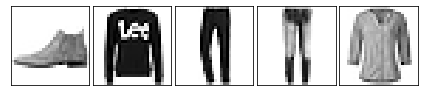

In [39]:
# Display random images from the test set, the ground truth labels and the network's predictions
net.eval()
with torch.no_grad():
    images, labels = iter(testloader).next()
    tests.plot_images(images[:5], n_rows=1)
    
    # Compute predictions
    images = images.to(device)
    y = net(images)

print('Ground truth labels: ', ' '.join('%10s' % classes[labels[j]] for j in range(5)))
print('Predictions:         ', ' '.join('%10s' % classes[j] for j in y.argmax(dim=1)))

In [40]:
# Compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)
assert accuracy > 0.85, "Poor accuracy {:.3f}".format(accuracy)
print('Success')

Accuracy of the network on the test images: 0.890
Success
